In [1]:
import pandas as pd

In [2]:
# Load the data
df = pd.read_csv('./faces/fold_0_data.txt', sep="\t")

In [3]:
print(df.shape)
print(df.columns)
df.head()

(4484, 12)
Index(['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'],
      dtype='object')


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [4]:
# Load the other dataframes
df1 = pd.read_csv('./faces/fold_1_data.txt', sep="\t")
df2 = pd.read_csv('./faces/fold_2_data.txt', sep="\t")
df3 = pd.read_csv('./faces/fold_3_data.txt', sep="\t")
df4 = pd.read_csv('./faces/fold_4_data.txt', sep="\t")

# Concatenate all the dataframes
df = pd.concat([df, df1, df2, df3, df4]).reset_index(drop=True)

In [5]:
print(df.shape)
print(df.columns)
df.head()

(19370, 12)
Index(['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'],
      dtype='object')


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [6]:
df['gender'].value_counts()

gender
f    9372
m    8120
u    1099
Name: count, dtype: int64

In [7]:
# sample 10000 images, with an equal number of each gender
df_male = df[df['gender'] == 'm'].sample(n=5000, random_state=23)
df_female = df[df['gender'] == 'f'].sample(n=5000, random_state=23)
df = pd.concat([df_male, df_female]).reset_index(drop=True)
print(df['gender'].value_counts())

gender
m    5000
f    5000
Name: count, dtype: int64


In [8]:
# drop the rows with u or nan for gender
df = df[(df['gender'] != 'u') & (df['gender'].notnull())]
df['gender'].value_counts()

gender
m    5000
f    5000
Name: count, dtype: int64

In [9]:
# encode gender column as male
df['male'] = df['gender'].apply(lambda x: 1 if x == 'm' else 0)
df['male'].value_counts()

male
1    5000
0    5000
Name: count, dtype: int64

In [10]:
# Create a new column with the path to the images
df['path'] = df['user_id'] + '/' + "coarse_tilt_aligned_face." + df['face_id'].astype(str) + "." + df['original_image']
df['path'].head()

0    62282816@N03/coarse_tilt_aligned_face.1470.117...
1    10792106@N03/coarse_tilt_aligned_face.533.1108...
2    37303189@N08/coarse_tilt_aligned_face.84.88635...
3    50739822@N00/coarse_tilt_aligned_face.1367.988...
4    112114373@N07/coarse_tilt_aligned_face.1198.11...
Name: path, dtype: object

In [11]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image


dim = 224


class ImageDataset(Dataset):
  def __init__(self, annotations_df, img_dir, dim=dim, transform=None, target_transform=None):
    self.annotations_df = annotations_df
    self.img_dir = img_dir
    self.dim = dim
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.annotations_df)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.annotations_df.loc[idx, 'path'])
    # read the image and resize
    image = Image.open(img_path).convert("RGB")
    image = image.resize((self.dim, self.dim))
    image = ToTensor()(image)
    label = self.annotations_df.loc[idx, 'male']
    label = torch.tensor(label)
    if self.transform:
        image = self.transform(image, self.dim)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [12]:
from torchvision import transforms

def transform_image(image, dim):
  # data augmentation
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(dim, scale=(0.8, 1.0), ratio=(1.0,1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  ])
  return transform(image)

In [13]:
# Get train, validation and test sets (80-10-10)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=23)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=23)

# Create the datasets
train_dataset = ImageDataset(train_df.reset_index(drop=True), './faces/', dim=dim, transform=transform_image)
val_dataset = ImageDataset(val_df.reset_index(drop=True), './faces/', dim=dim)
test_dataset = ImageDataset(test_df.reset_index(drop=True), './faces/', dim=dim)

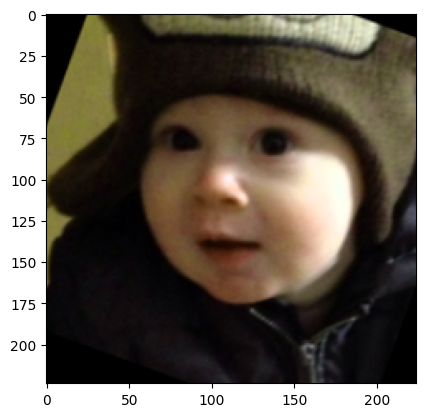

In [14]:
# show an image
image, label = train_dataset[1]
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [15]:
# Define the dataloaders
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Transfer Learning

In [16]:
# Load pretrained model
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights

vit_b_16 = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vit_b_16.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [17]:
# Check the number of parameters
total_params = sum([param.numel() for param in vit_b_16.parameters()])
print(f'{total_params:,} total parameters.')

86,567,656 total parameters.


In [18]:
# Define the loss function and the optimizer
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_b_16.parameters(), lr=0.0001)

# Define early stopping
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_loss = float('inf')

  def early_stop(self, loss):
    if loss < self.min_loss:
      self.min_loss = loss
      self.counter = 0
    elif loss > (self.min_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [19]:
# Train the model
n_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
min_val_loss = float('inf')

for epoch in range(n_epochs):
  print(f'===== Epoch {epoch+1} =====')
  train_loss = 0.0
  val_loss = 0.0
  train_accuracy = 0
  val_accuracy = 0

  # Training
  vit_b_16.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = vit_b_16(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_accuracy += (outputs.argmax(1) == labels).sum().item()
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  train_accuracy /= len(train_loader.dataset)
  train_accuracies.append(train_accuracy)

  print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

  # Validation
  vit_b_16.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = vit_b_16(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      val_accuracy += (outputs.argmax(1) == labels).sum().item()
  val_loss /= len(val_loader)
  val_losses.append(val_loss)
  val_accuracy /= len(val_loader.dataset)
  val_accuracies.append(val_accuracy)

  # Save the best model
  if val_loss < min_val_loss:
    torch.save(vit_b_16.state_dict(), 'vit_b_16_finetune.pth')
    min_val_loss = val_loss

  # Early stopping
  if early_stopper.early_stop(val_loss):
    print('Early stopping')
    break

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

===== Epoch 1 =====
Training Loss: 0.4464, Training Accuracy: 0.7947
Validation Loss: 0.2115, Validation Accuracy: 0.9130
===== Epoch 2 =====
Training Loss: 0.2116, Training Accuracy: 0.9137
Validation Loss: 0.2324, Validation Accuracy: 0.9180
===== Epoch 3 =====
Training Loss: 0.1791, Training Accuracy: 0.9267
Validation Loss: 0.2412, Validation Accuracy: 0.9020
===== Epoch 4 =====
Training Loss: 0.1260, Training Accuracy: 0.9497
Validation Loss: 0.2346, Validation Accuracy: 0.9140
===== Epoch 5 =====
Training Loss: 0.1136, Training Accuracy: 0.9556
Validation Loss: 0.1534, Validation Accuracy: 0.9350
===== Epoch 6 =====
Training Loss: 0.0969, Training Accuracy: 0.9621
Validation Loss: 0.1788, Validation Accuracy: 0.9380
===== Epoch 7 =====
Training Loss: 0.0881, Training Accuracy: 0.9670
Validation Loss: 0.1606, Validation Accuracy: 0.9420
===== Epoch 8 =====
Training Loss: 0.0681, Training Accuracy: 0.9756
Validation Loss: 0.1788, Validation Accuracy: 0.9440
===== Epoch 9 =====
Trai

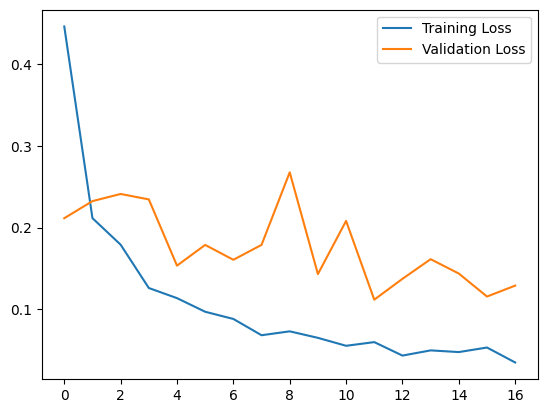

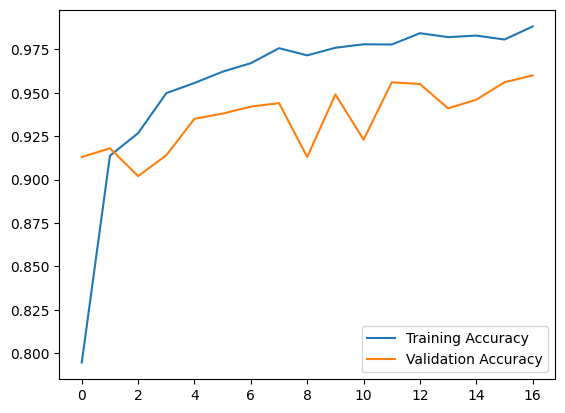

In [20]:
# Plot the losses and accuracies
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

In [22]:
# Evaluate the model
vit_b_16.load_state_dict(torch.load('vit_b_16_finetune.pth'))
vit_b_16.to(device)

vit_b_16.eval()
test_accuracy = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = vit_b_16(images)
    test_accuracy += (outputs.argmax(1) == labels).sum().item()
test_accuracy /= len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\waiho\AppData\Local\Temp\ipykernel_14512\3670003664.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_b_16.load_state_dict(torch.load('vit_b_16_finetune.pth')

Test Accuracy: 0.9550


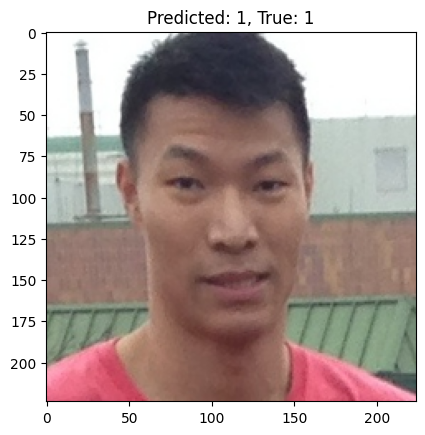

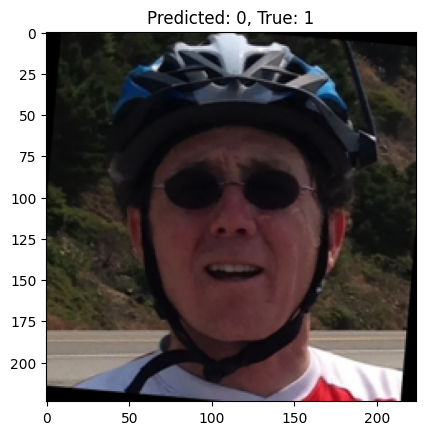

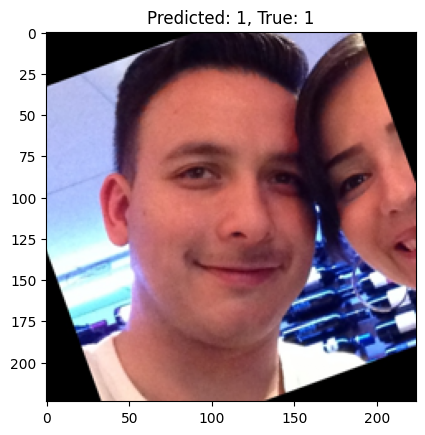

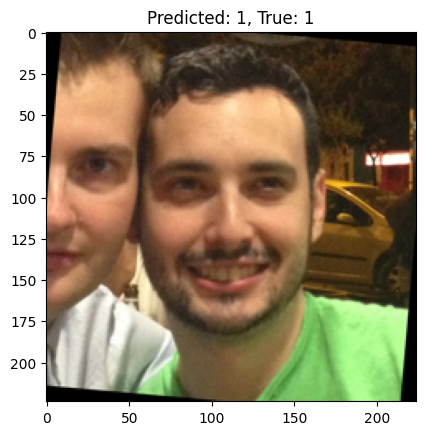

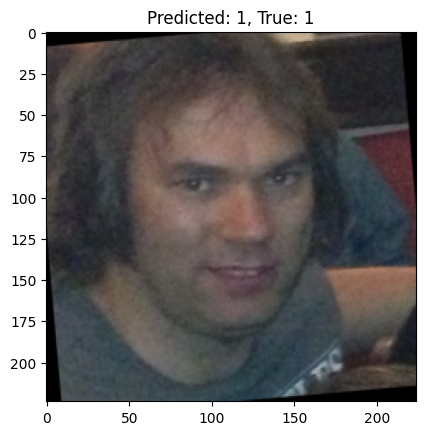

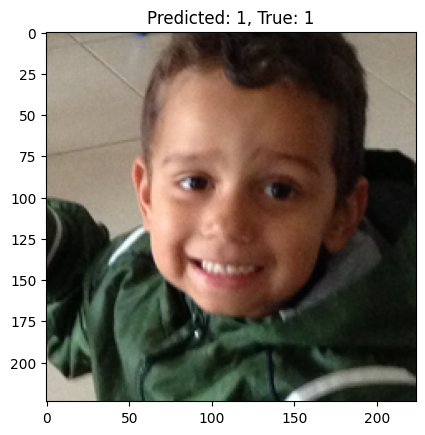

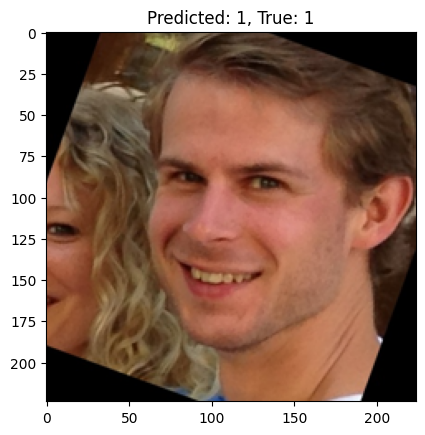

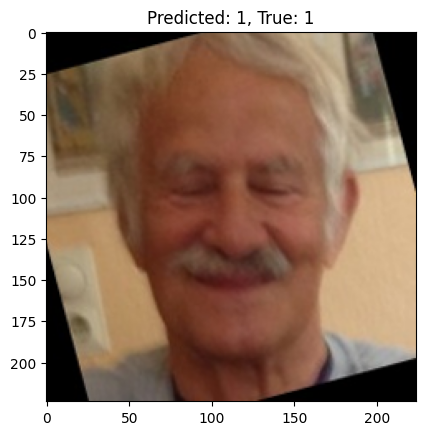

In [23]:
# Show some predictions
vit_b_16.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = vit_b_16(images)
predicted = outputs.argmax(1)
for i in range(8):
  plt.imshow(images[i].cpu().permute(1, 2, 0))
  plt.title(f'Predicted: {predicted[i]}, True: {labels[i]}')
  plt.show()